## Lihua Dong (ld457)
## Duo Sun (ds2324)
## Ziming Zeng (zz494)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Load the data

In [2]:
%%time
data = pd.read_csv('mdma-pitch-20180328.dat.gz', compression='gzip', header=None)

CPU times: user 3min 56s, sys: 3min 12s, total: 7min 8s
Wall time: 9min 52s


### Find the execution and cancellation order 

In [3]:
%%time
d = data[0]
order_e_loc = d.apply(lambda x: x[9] == 'E')
order_e = d[order_e_loc]
order_x_loc = d.apply(lambda x: x[9] == 'X')
order_x = d[order_x_loc]

CPU times: user 2min 44s, sys: 6min 29s, total: 9min 14s
Wall time: 17min 17s


### Find the add and hidden order for Amazon

In [4]:
%%time
amzn_loc = d.apply(lambda x: x[29:35].strip() == 'MSFT')
amzn = d[amzn_loc]

CPU times: user 1min 55s, sys: 3min, total: 4min 55s
Wall time: 8min 50s


In [5]:
%%time
amzn_df = []
amzn_idx = []
for index, order in amzn.iteritems():
    time = int(order[1:9])
    order_type = order[9]
    order_id = order[10:22]
    if order_type == 'A':
        side = order[22]
    else:
        side = None
    size = int(order[23:29])
    symbol = order[29:35].strip()
    price = float(order[35:45])/10000
    amzn_df.append({'time': time, 'order_id': order_id, 'symbol': symbol, 'order_size': size,
                    'price': price, 'side':side, 'order_type': order_type})
    amzn_idx.append(index)
amzn_df = pd.DataFrame(amzn_df, index=amzn_idx)

CPU times: user 1.97 s, sys: 2.02 s, total: 3.99 s
Wall time: 5.32 s


In [6]:
# The dataframe that include add and hidden order
amzn_df.head()

,order_id,order_size,order_type,price,side,symbol,time
93343,IT1KTC0000NB,10,A,90.20,S,MSFT,28262586
94035,IT1KTC0000NE,10,A,90.17,B,MSFT,28282188
94078,IT1KTC0000NF,10,A,90.20,S,MSFT,28283945
98132,IT1KTC0000OP,10,A,90.30,S,MSFT,28438929
103896,IT1KTC0000P4,10,A,90.23,S,MSFT,28630823


### Find the cancellation order for Amazon

In [7]:
order_id_lst = amzn_df['order_id'].values

In [8]:
%%time
order_x_id = order_x.apply(lambda x: x[10:22])
order_x_time = order_x.apply(lambda x: int(x[1:9]))
order_x_size = order_x.apply(lambda x: int(x[22:28]))
order_x_loc = order_x_id.isin(order_id_lst)

amzn_x_id = order_x_id[order_x_loc]
amzn_x_time = order_x_time[order_x_loc]
amzn_x_size = order_x_size[order_x_loc]

amzn_x = pd.DataFrame({'time': amzn_x_time, 'order_id': amzn_x_id, 'order_size': amzn_x_size})

CPU times: user 3min 48s, sys: 3min 31s, total: 7min 19s
Wall time: 10min 52s


In [9]:
def find_x_price(x_order):
    return amzn_df.loc[(amzn_df['order_id']==x_order['order_id']) & (amzn_df.index < x_order.name), 'price'].iloc[-1]

In [10]:
%%time
amzn_x_price = amzn_x.apply(find_x_price, axis = 1)

CPU times: user 1h 47min 37s, sys: 14.5 s, total: 1h 47min 52s
Wall time: 1h 48min 10s


In [11]:
amzn_x['price'] = amzn_x_price
amzn_x['symbol'] = 'MSFT'
amzn_x['side'] = None
amzn_x['order_type'] = 'X'

### Find the execution order for Amazon

In [12]:
%%time
order_e_id = order_e.apply(lambda x: x[10:22])
order_e_time = order_e.apply(lambda x: int(x[1:9]))
order_e_size = order_e.apply(lambda x: int(x[22:28]))

order_e_loc = order_e_id.isin(order_id_lst)
amzn_e_id = order_e_id[order_e_loc]
amzn_e_time = order_e_time[order_e_loc]
amzn_e_size = order_e_size[order_e_loc]

amzn_e = pd.DataFrame({'time': amzn_e_time, 'order_id': amzn_e_id, 'order_size': amzn_e_size})

CPU times: user 22.9 s, sys: 1min 46s, total: 2min 9s
Wall time: 4min 34s


In [13]:
def find_e_price(e_order):
    return amzn_df.loc[(amzn_df['order_id']==e_order['order_id']) & (amzn_df.index < e_order.name), 'price'].iloc[-1]

In [14]:
%%time
amzn_e_price = amzn_e.apply(find_e_price, axis = 1)

CPU times: user 1min 59s, sys: 495 ms, total: 2min
Wall time: 2min 1s


In [15]:
amzn_e['price'] = amzn_e_price
amzn_e['symbol'] = 'MSFT'
amzn_e['side'] = None
amzn_e['order_type'] = 'E'

## Structured Limit Order Book for AMZN

In [16]:
amzn_final = pd.concat([amzn_df, amzn_e, amzn_x], axis = 0)

/Users/lihuadong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [17]:
def standard_time(time):
    hours, milliseconds = divmod(time, 3600000)
    minutes, milliseconds = divmod(milliseconds, 60000)
    seconds = float(milliseconds) / 1000
    return "%i:%02i:%06.3f" % (hours, minutes, seconds)

In [18]:
amzn_final.sort_index(inplace = True)

In [19]:
amzn_final['standard_time'] = amzn_final['time'].apply(standard_time)
amzn_final.head()

,order_id,order_size,order_type,price,side,symbol,time,standard_time
93343,IT1KTC0000NB,10,A,90.20,S,MSFT,28262586,7:51:02.586
93344,IT1KTC0000NB,10,X,90.20,None,MSFT,28262586,7:51:02.586
94035,IT1KTC0000NE,10,A,90.17,B,MSFT,28282188,7:51:22.188
94036,IT1KTC0000NE,10,X,90.17,None,MSFT,28282188,7:51:22.188
94078,IT1KTC0000NF,10,A,90.20,S,MSFT,28283945,7:51:23.945


In [21]:
amzn_final.to_csv('msft.csv')

## Find the best bid and best ask

In [22]:
%%time
bid_price = []
bid_id = []
bid_size = []
ask_price = []
ask_id = []
ask_size = []
best_bid = pd.Series(index = amzn_final.index)
best_ask = pd.Series(index = amzn_final.index)

for idx, order in amzn_final.iterrows():
    
    order_type = order['order_type']
    order_id = order['order_id']
    price = order['price']
    size = order['order_size']
    
    if order_type == 'A':
        
        if order['side'] == 'B':
            bid_price.append(price)
            bid_id.append(order_id)
            bid_size.append(size)
        elif order['side'] == 'S':
            ask_price.append(price)
            ask_id.append(order_id)
            ask_size.append(size)
    
    elif order_type == 'E' or order_type == 'X':
        
        try:
            index = bid_id.index(order_id)
            side = 1
        except ValueError:
            index = ask_id.index(order_id)
            side = 0
            
        if side == 1:
            bid_size[index] -= size
            if bid_size[index] == 0:
                bid_price.pop(index)
                bid_id.pop(index)
                bid_size.pop(index) 
        else:
            ask_size[index] -= size
            if ask_size[index] == 0:
                ask_price.pop(index)
                ask_id.pop(index)
                ask_size.pop(index)
    
    if bid_price:
        best_bid[idx] = max(bid_price)
    
    if ask_price:
        best_ask[idx] = min(ask_price)
        

CPU times: user 1min 7s, sys: 381 ms, total: 1min 8s
Wall time: 1min 10s


## Plot best bid and best ask

In [23]:
%%time
order_time = amzn_final['standard_time'].apply(lambda x: x[:-7])
time_range = pd.date_range(order_time.iloc[0], order_time.iloc[-1], freq='1min').time
order_time = pd.to_datetime(order_time, format='%H:%M').apply(lambda x: x.time())

best_bid_ask = pd.DataFrame({'time': order_time, 'best_bid': best_bid, 'best_ask': best_ask})
best_bid_ask = best_bid_ask.groupby('time').last().fillna(-1)

best_bid_ask_df = pd.DataFrame(index = time_range, columns=['best_bid', 'best_ask'])
best_bid_ask_df.loc[best_bid_ask.index, 'best_bid'] = best_bid_ask['best_bid']
best_bid_ask_df.loc[best_bid_ask.index, 'best_ask'] = best_bid_ask['best_ask']
best_bid_ask_df = best_bid_ask_df.fillna(method = 'ffill').replace(-1, np.nan)

CPU times: user 3.61 s, sys: 1.05 s, total: 4.66 s
Wall time: 6.39 s


(array([84., 86., 88., 90., 92., 94., 96.]),
 <a list of 7 Text yticklabel objects>)

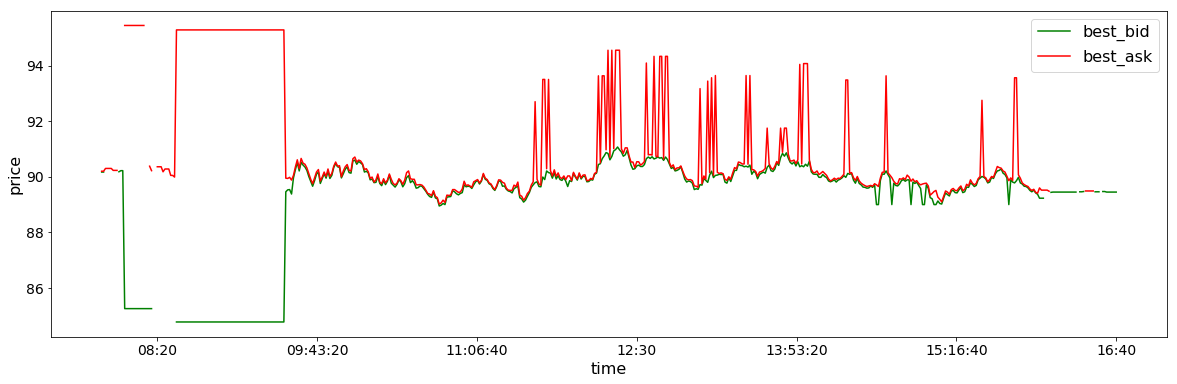

In [24]:
best_bid_ask_df.plot(figsize=(20,6), color = ['g', 'r'])
plt.legend(fontsize=16)
plt.xlabel('time', fontsize=16)
plt.ylabel('price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Average and standard deviation of best bid, best ask and trade price

In [23]:
delta_t = -amzn_final['time'].diff(-1)
best_bid_df = pd.DataFrame({'delta_t': delta_t, 'best_bid': best_bid}).dropna()
bid_mean = np.sum(best_bid_df['delta_t'] * best_bid_df['best_bid']) / np.sum(best_bid_df['delta_t'])
bid_std = np.sqrt(np.sum((best_bid_df['best_bid'] - bid_mean)**2 * best_bid_df['delta_t']) / np.sum(best_bid_df['delta_t']))
print("The average of best bid is ", bid_mean)
print("The standard deviation of best bid is ", bid_std)

The average of best bid is  1391.8752834409936
The standard deviation of best bid is  25.891702803585986


In [24]:
best_ask_df = pd.DataFrame({'delta_t': delta_t, 'best_bid': best_ask}).dropna()
ask_mean = np.sum(best_ask_df['delta_t'] * best_ask_df['best_bid']) / np.sum(best_ask_df['delta_t'])
ask_std = np.sqrt(np.sum((best_ask_df['best_bid'] - bid_mean)**2 * best_ask_df['delta_t']) / np.sum(best_ask_df['delta_t']))
print("The average of best ask is ", ask_mean)
print("The standard deviation of best ask is ", ask_std)

The average of best ask is  1461.037641765869
The standard deviation of best ask is  82.32953707871299


In [25]:
bid = amzn_final.loc[amzn_final['side'] == 'B', :]
ask = amzn_final.loc[amzn_final['side'] == 'S', :]
trade = amzn_final.loc[amzn_final['order_type'].isin(['P', 'E']), :]

In [26]:
trade_mean = np.sum(trade['price'] * trade['order_size']) / np.sum(trade['order_size'])
trade_std = np.sqrt(np.sum((trade['price']-trade_mean)**2 * trade['order_size']) / np.sum(trade['order_size']))
print("The average of trade price is ", trade_mean)
print("The standard deviation of trade price is ", trade_std)

The average of trade price is  1426.3550487489845
The standard deviation of trade price is  14.515818492596793


## Number of quotes for bid, ask and execution

In [27]:
bid_num = len(bid)
ask_num = len(ask)
trade_num = len(trade)
print("The number of quotes for bid is ", bid_num)
print("The number of quotes for ask is ", ask_num)
print("The number of quotes for execution is ", trade_num)

The number of quotes for bid is  23865
The number of quotes for ask is  40481
The number of quotes for execution is  7828


## Order size distribution

In [28]:
add = amzn_final.loc[amzn_final['order_type'].isin(['A']), 'order_size']
cancel = amzn_final.loc[amzn_final['order_type'].isin(['X']), 'order_size']
hidden = amzn_final.loc[amzn_final['order_type'].isin(['P']), 'order_size']
execution = amzn_final.loc[amzn_final['order_type'].isin(['E']), 'order_size']

size_dist = pd.DataFrame({'A': add.describe(), 'E': execution.describe(), 
                          'P': hidden.describe(), 'X': cancel.describe()}).round(2)
size_dist

,A,E,P,X
count,64346.00,709.00,7119.00,78620.00
mean,44.46,48.64,25.93,35.95
std,38.47,40.51,38.50,37.96
min,1.00,1.00,1.00,1.00
25%,6.00,9.00,2.00,3.00
50%,36.00,40.00,5.00,21.00
75%,99.00,98.00,25.00,67.00
max,300.00,210.00,600.00,300.00


## Distribution of time between order updated

In [29]:
order_index = amzn_final.index
def last_time(order):
    last_order_time = amzn_final.loc[(amzn_final['order_id']==order['order_id']) & (order_index < order.name), 'time']
    return last_order_time.iloc[-1]

In [30]:
%%time
cancel = amzn_final.loc[amzn_final['order_type'].isin(['X']), ['order_id', 'time', 'order_type']]
last_cancel_time = cancel.apply(last_time, axis = 1)

CPU times: user 19min 49s, sys: 3.23 s, total: 19min 52s
Wall time: 19min 57s


In [31]:
%%time
execution = amzn_final.loc[amzn_final['order_type'].isin(['E']), ['order_id', 'time', 'order_type']]
last_e_time = execution.apply(last_time, axis = 1)

CPU times: user 12.3 s, sys: 547 ms, total: 12.8 s
Wall time: 14 s


In [32]:
x_time = cancel['time'] - last_cancel_time
e_time = execution['time'] - last_e_time

In [33]:
time_dist = pd.DataFrame({'E': e_time.describe(), 'X': x_time.describe()}).round(2)
time_dist['A'] = 0
time_dist['P'] = 0

In [35]:
time_dist

,E,X,A,P
count,709.00,78620.00,0,0
mean,4409.83,5512.19,0,0
std,31719.56,160294.72,0,0
min,0.00,0.00,0,0
25%,0.00,30.00,0,0
50%,186.00,138.00,0,0
75%,1288.00,394.00,0,0
max,550295.00,23399076.00,0,0
